In [1]:
import numpy as np
import cv2
print('OpenCV version used:', cv2.__version__)
from glob import glob

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,20)

OpenCV version used: 4.1.0


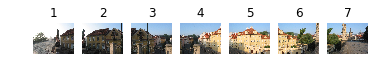

In [2]:
def imread(imgpath):
    return cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

def imshow(img, cmap='gray', sub=None, title=None, ax='off'):
    if sub is not None:
        plt.subplot(*sub)
    if title is None:
        title = img.shape
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.grid(False)
    plt.axis(ax)
    if sub is None:
        plt.show()

imgs = []
for i, imgpath in enumerate(sorted(glob("./img/bridge_*.jpg"), reverse=True)):
    img = imread(imgpath)
    imgs.append(img)
    imshow(img, sub=(1,7,i+1), title=i+1)
plt.show()

w = imgs[0].shape[1] 
h = imgs[0].shape[0]

In [3]:
def get_matches(img1, img2, n=30, show_matches=False):
    # Detect & describe
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    
    # Match
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Get first n matches
    matches = matches[:n]
    if show_matches:
        img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
        imshow(img3)
    return {'kp1': kp1, 'kp2': kp2, 'matches': matches}

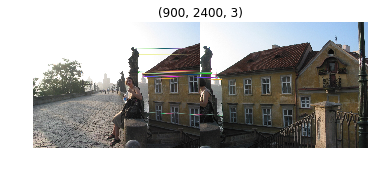

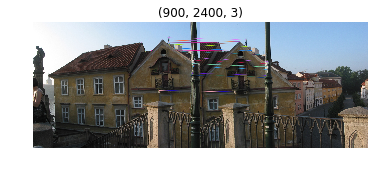

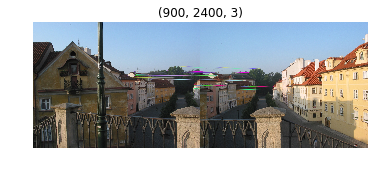

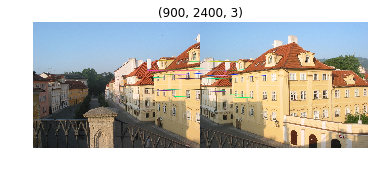

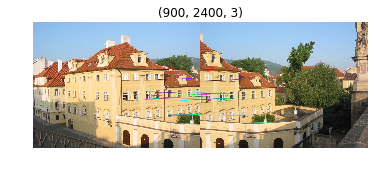

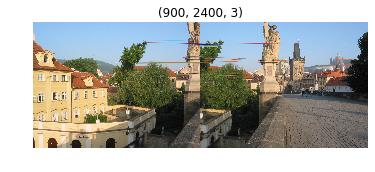

In [4]:
adjacents = []
for i in np.arange(len(imgs)-1):
    adjacents.append(get_matches(imgs[i], imgs[i+1], n=30, show_matches=True))

## Task 1.1
Implement basic functions for homogeneous coordinates and computation of the transfer error

In [61]:
def homogenize(pts):
    """Transform image points from 2D coordinates to homogeneous coordinates. 
    Args:
        pts -- (N,2) array of image points in 2D
    Returns:
        pts_h -- (N,3) array -- pts in homogeneous representation
    """
    ########### please implement me ###########
    ones = np.ones((1, 1))
    return np.concatenate([pts.reshape(1, -1), ones], axis=1)
    ###########################################

def renormalize(pts):
    """Renormalize image points in homogeneous representation
      (i.e. project on the plane z=1, divide by the third coordinate)
    Args:
        pts -- (N,3) array of image points in homogeneous representation
    Returns:
        pts_norm -- (N,3) array -- pts divided by the third coordinate
    """
    ########### please implement me ###########
    return pts / pts[:, -1].reshape(pts.shape[0], 1)
    ###########################################
    
def transfer_error(pts1, pts2, H, reduce_mean=True):
    """Compute transfer error of the transformation H for provided
    correspondences, i.e. the euclidean distances between pts2
    and pts1 transferred by H. Reduce to mean if not forced reduce_mean=False.
    Args:
        pts1 -- (N,2) array of image points
        pts2 -- (N,2) array of image points
        H -- (3,3) homography matrix
        reduce_mean -- if True, then computes mean transfer error
    Returns:
        err -- transfer error value
    """
    ########### please implement me ###########
    s = 0
    for i in range(pts1.shape[0]):
#         s += np.linalg.norm(homogenize(pts1[i]) - renormalize(H.dot(homogenize(np.squeeze(pts2)[i]).T).squeeze().reshape(1, -1))) ** 2
#         s += np.linalg.norm(homogenize(pts1[i]) - renormalize(homogenize(np.squeeze(pts2)[i]).dot(H).squeeze().reshape(1, -1))) ** 2
        s += np.linalg.norm(homogenize(pts1[i]) - renormalize(np.linalg.solve(H, homogenize(np.squeeze(pts2)[i]).T).squeeze().reshape(1, -1))) ** 2
    return s
    ###########################################

In [14]:
# np.linalg.norm(np.array([[24, 2], [4, 1]]) - np.array([[12, 6], [6, 5]]))
np.linalg.norm(np.array([818.6575, 400.61963]) - np.array([146.81091, 410.5729]))
np.linalg.norm(np.array([741.,      192.     ]) - np.array( [ 66.  ,    186.      ]))
np.linalg.norm(np.array([787.9681, 366.33603]) - np.array( [114.04802,  373.24805 ]))

673.9555254226253

In [59]:
renormalize(H.dot(homogenize(np.squeeze(dst_pts)[0]).T).squeeze().reshape(1, -1))
np.linalg.norm(homogenize(src_pts[0]) - renormalize(homogenize(np.squeeze(dst_pts)[0]).dot(H).squeeze().reshape(1, -1)))**2
# H.dot(homogenize(np.squeeze(dst_pts)[0]).T)
# homogenize(np.squeeze(dst_pts)[0]).dot(H)
renormalize(np.linalg.solve(H, homogenize(np.squeeze(dst_pts)[0]).T).squeeze().reshape(1, -1))

array([[1.03193897e+03, 3.72962119e+02, 1.00000000e+00]])

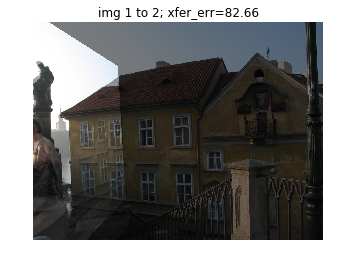

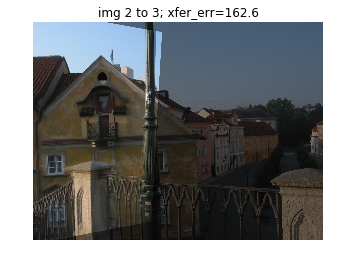

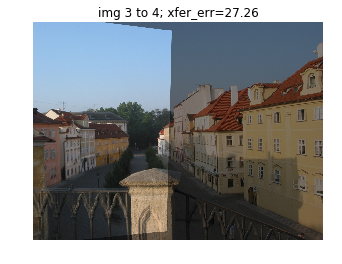

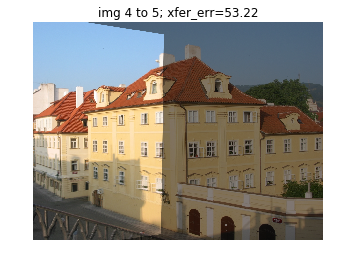

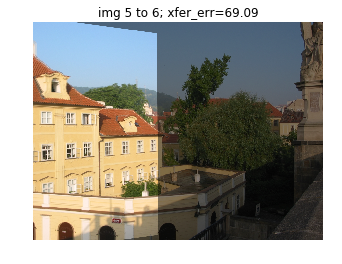

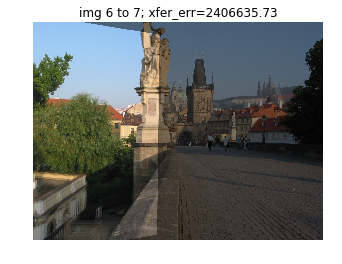

In [62]:
# Compute homography for adjacent images
for i in np.arange(len(imgs)-1):
    adjacent_pair = adjacents[i]
    kp1 = adjacent_pair['kp1']
    kp2 = adjacent_pair['kp2']
    matches = adjacent_pair['matches']
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    
    H = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0] # use your function here instead
    adjacents[i]['homography'] = H
#     print(np.squeeze(src_pts), np.squeeze(dst_pts), H)
#     break
    err = transfer_error(np.squeeze(src_pts), np.squeeze(dst_pts), H)
    adjacents[i]['transfer_error'] = err
    
    img1 = imgs[i]
    img2 = imgs[i+1]
    img1to2 = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
    imshow(cv2.addWeighted(img2,0.5,img1to2,0.5,0), title='img {} to {}; xfer_err={}'.format(i+1,i+2,np.round(err,2)))

## Task 1.2
Draw 6 histograms of transfer errors of all correspondences (do not reduce to means) on a single plot. Analyse the result. How to make it better? See an example:
![histogram_xfer_err](./img/histogram_xfer_err.png)

## Task 2. Projective panorama
Compute homographies $H_{i\_to\_4}$ for all $i = \overline{1,7}$ mapping images into a reference image 4 (thus $H_{4\_to\_4}$. is identity). Then construct inverse homographies $H_{4\_to\_i}$.
Construct a projective panoramic image by combining together images 2...6 transformed to the image plane of the image 4. Make smooth transition between images with alpha blending, poisson blending, pyramid blending etc. As a basic result you might get this:
![base_pjoective_panorama](./img/base_pjoective_panorama.png)

In [11]:
reference_img = imgs[3]

Hito4 = [np.eye(3)]
H4toi = [np.eye(3)]

## Task 3.1. Cylindrical panorama
Construct calibration matrix $K$ using the actual image size and the original EXIF. All the images share the same calibration. Establish a transformation between each image plane and the coordinate system of the cylinder, described below.

In [24]:
EXIF = {
    "ImageWidth": 2400,
    "ImageHeight": 1800,
    "FocalPlaneXResolution": 9600.0,
    "FocalPlaneYResolution": 9590.47619047619,
    "FocalPlaneResolutionUnit": "inch",
    "FocalLength": 7.4,
    "FocalLengthUnit": "mm",
    "ImageDownscaleFactor": 2}

![cylinder](./img/cylinder.jpg)

The cylinder is defined in the CS $\gamma$ (blue) of the image 4 (green) such that:

* cylinder axis is equal to y-axis of $\gamma$,
* image plane of the image 4 is tangential to the cylinder,
* image CS defined on the cylinder surface has square pixels and equal horizontal resolution in the line where it touches the image 4.

This leads that the cylinder has radius = 1 in the γ system. The cylinder surface is a set of points $(x_{\gamma} ~ y_{\gamma} ~ z_{\gamma})^\top$ such that

\begin{equation}
x_{\gamma}^2 + z_{\gamma}^2 = 1
\end{equation}

For parametrisation of the cylinder surface we define two CSs:
* the first $\alpha$ (magenta) is based on the cylinder $\gamma$,
* the second $cp$ (cylindrical pyramid, red) is pixel-based system of panoramic image.

1) The surface of the cylinder is parametrised by circumference length which is a rotation angle (since radius=1) and by the $y_{\gamma}$ coordinate. Since the ray $\lambda (x_{\gamma} ~y_{\gamma}~ z_{\gamma})^\top$ intersects the cylinder in the point $\lambda=\frac{1}{\sqrt{x_{\gamma}^2 + z_{\gamma}^2}}$
the parametrisation is following:

\begin{equation}
(a_{c\gamma} ~ y_{c\gamma})^\top = (\mbox{the angle given by } x_{\gamma} \mbox{ and } z_{\gamma} ~ \frac{y_{\gamma}}{\sqrt{x_{\gamma}^2 + z_{\gamma}^2}})^\top
\end{equation}

2) the pixel size must be applied and image origin adjusted. Since the horizontal pixel size is 1/K(1,1) measured in units given by γ system, this leads to

\begin{equation}
(x_{cp} ~ y_{cp})^\top = K_{11}  (a_{c\gamma} ~ y_{c\gamma})^\top + (x_{0c} ~ y_{0c} )^\top
\end{equation}

where the origin $(x_{0c}; y_{0c})$ must be found such that all pixels from the input images will fit into the resulting panorama.

## Task 3.2
Construct a panoramic image from all the images mapped onto the cylinder

# Task 4. Your own panorama
Construct a cylindrical panorama from a set of photos taken by you. Don't use panorama functionality in your phone!!!11 Calibrate your phone camera from orthogonal vanishing points to estimate camera matrix $K$ as in the calibration practical work